# ABOVE AC9 Data Processing  

## Checking Sample Replicates - Manually remove poor samples

**Authors:** Catherine Kuhn, Elena Terzić and Anna Simpson

**Last Updated:** September 12th, 2018

### Import libraries

In [1]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec

### Functions

#### Plots absorption/attenuation for multiple replicates (combination of site_date, filtered/unfiltered, and a/c)

In [95]:
def plotting_absorption(list_of_files, check='F', title='Title'):
    labels_list = []
    for filename in range(len(list_of_files)):   
            df = pd.read_csv(list_of_files[filename], skiprows = 0, delimiter= '\t')         
            df.reset_index(inplace=True, drop=False)
            df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
            Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2= list_of_files[filename].split('/')[-1].split('.')[0].split('_')
            repname = 'Rep '+Rep
            labels_list.append(repname)
            plt.plot('wl','mean',data=df,label=repname)
            #plt.scatter('wl', 'a_mean', data = df)
            plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
            if check == 'F':
                pass
            else:
                if 'FLAG' in check[list_of_files[filename]]:
                    plt.text(650, df['mean'].mean(), check[list_of_files[filename]]+' '+repname, fontsize=15, color="red")
    plt.ylabel('a [1/m]')
    plt.title(title)
    plt.legend(labels_list)
    return plt

In [73]:
metadata.head()

,Analysis_Type,Date,ID,Raw_File_Path,Rep,Sample_Type,Sensor,Site,Temp,Cleaned_raw_file_path,Averaged_file_path,Conf
0,a,70718,AC9_070718_sea_cal_a_1_T20_6,/Users/Petrichor/Documents/FreshwatersOpticsTo...,1,cal,AC9,sea,20.6,/Users/Petrichor/Documents/FreshwatersOpticsTo...,/Users/Petrichor/Documents/FreshwatersOpticsTo...,0.021394
1,a,70718,AC9_070718_sea_cal_a_2_T20_9,/Users/Petrichor/Documents/FreshwatersOpticsTo...,2,cal,AC9,sea,20.9,/Users/Petrichor/Documents/FreshwatersOpticsTo...,/Users/Petrichor/Documents/FreshwatersOpticsTo...,0.000588
2,a,70718,AC9_070718_sea_cal_a_3_T20_9,/Users/Petrichor/Documents/FreshwatersOpticsTo...,3,cal,AC9,sea,20.9,/Users/Petrichor/Documents/FreshwatersOpticsTo...,/Users/Petrichor/Documents/FreshwatersOpticsTo...,0.000553
3,c,70718,AC9_070718_sea_cal_c_1_T20_6,/Users/Petrichor/Documents/FreshwatersOpticsTo...,1,cal,AC9,sea,20.6,/Users/Petrichor/Documents/FreshwatersOpticsTo...,/Users/Petrichor/Documents/FreshwatersOpticsTo...,0.000296
4,c,70718,AC9_070718_sea_cal_c_2_T20_6,/Users/Petrichor/Documents/FreshwatersOpticsTo...,2,cal,AC9,sea,20.6,/Users/Petrichor/Documents/FreshwatersOpticsTo...,/Users/Petrichor/Documents/FreshwatersOpticsTo...,0.554332


## Inputs

In [23]:
metadata_updated_filepath = os.path.abspath('..')+'/Metadata/project_metadata_updated.csv'
replicate_directory_name = '2_summary_stats'
replicate_pass_directory_name = '2_summary_stats_pass_manual'

replicate_files_location = os.path.abspath('..')+'/Data/'+replicate_directory_name
replicate_pass_directory_location = os.path.abspath('..')+'/Data/'+replicate_pass_directory_name

In [ ]:
metadata = pd.read_csv(metadata_updated_filepath, skiprows=0, delimiter= '\t')

## Read all file paths into dictionary

#### This loop goes through the rows of the metadata file, creates a dictionary in which the keys are date_site and the entries are dictionaries where the keys are SampleType_AnalysisType (example: fil_a) and the entries are lists of file directories.

In [55]:
metadata = pd.read_csv(metadata_updated_filepath, skiprows=0, delimiter= '\t')
plotting_dict = {}
conf_check = {}
for index, row in metadata.iterrows():
    Site, Date, Analysis_Type, Sample_Type, Averaged_file_path, Conf = row['Site'], row['Date'], row['Analysis_Type'], row['Sample_Type'], row['Averaged_file_path'], row['Conf']
    SiteDate = Site+'_'+str(Date)
    Type = Sample_Type+'_'+Analysis_Type
    conf_check[Averaged_file_path] = Conf
    if SiteDate not in plotting_dict:
        plotting_dict[SiteDate] = {Type:[Averaged_file_path]}
    elif Type not in plotting_dict[SiteDate]:
        plotting_dict[SiteDate][Type] = [Averaged_file_path]
    else:
        plotting_dict[SiteDate][Type].append(Averaged_file_path)
        

In [69]:
from math import exp
for i in conf_check:
    df = pd.read_csv(i, skiprows = 0, delimiter= '\t')
    df.rename(columns = {'c_std':'std','a_std':'std'}, inplace = True)
    mean_std = df['std'].mean()
    if exp(mean_std) > exp(conf_check[i]+1):
        conf_check[i] = 'FLAG'
    else:
        conf_check[i] = ''

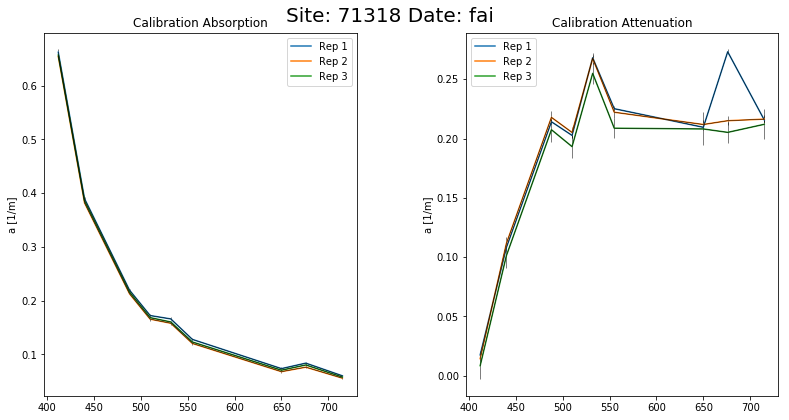

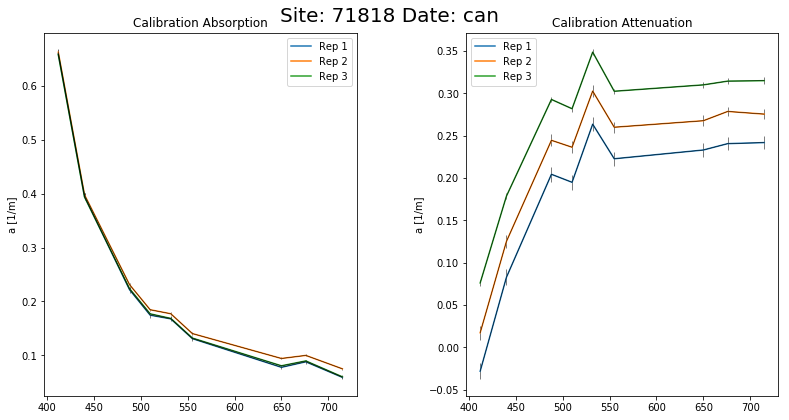

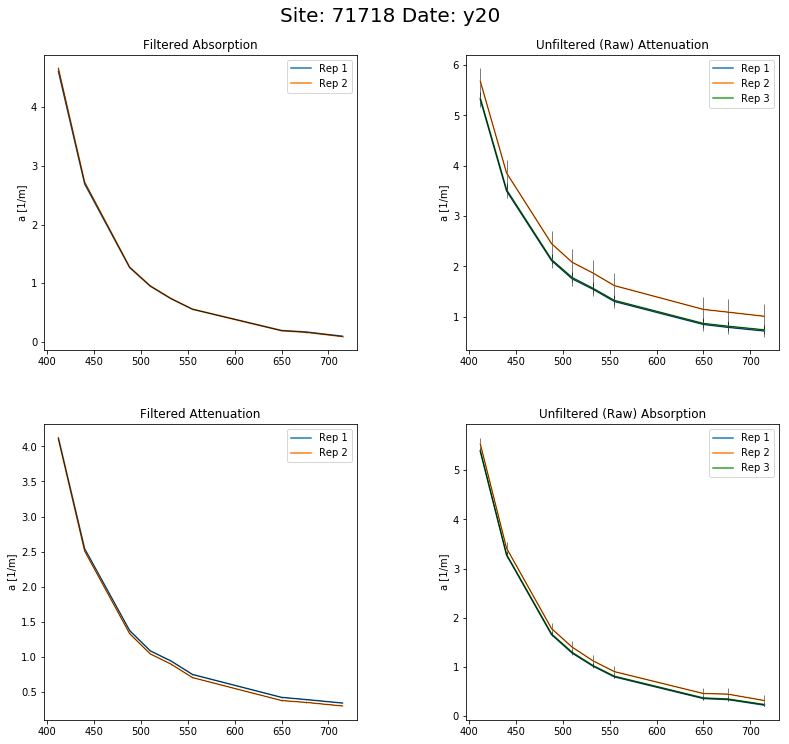

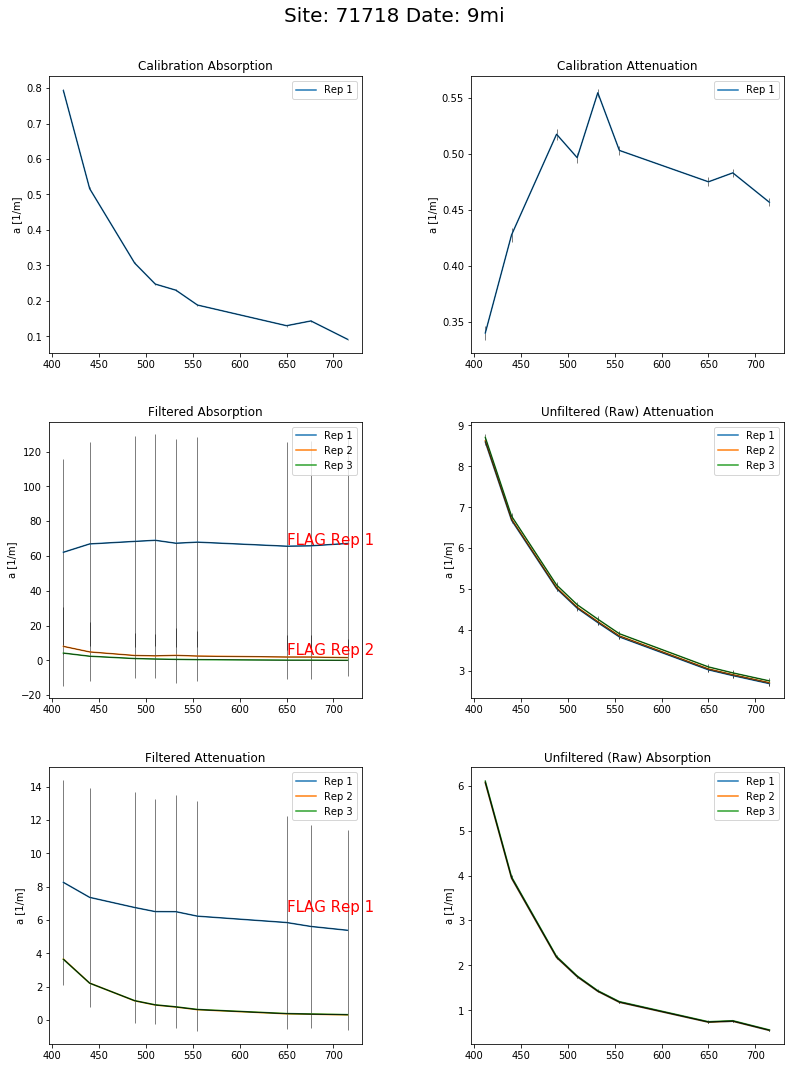

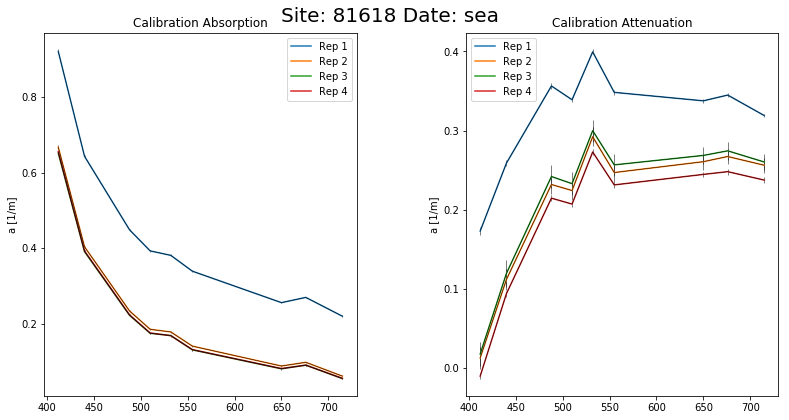

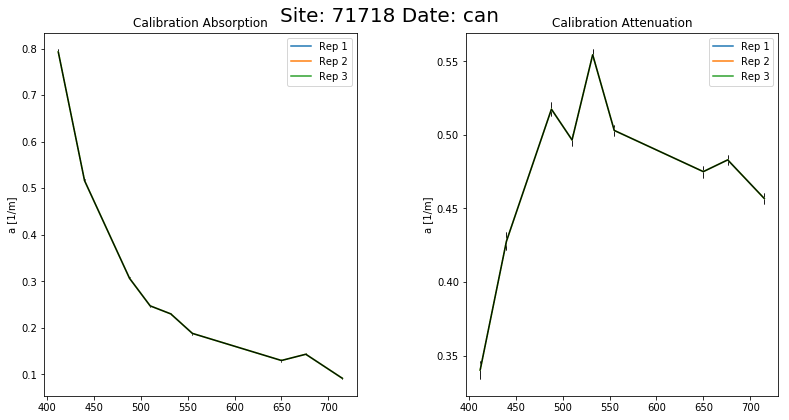

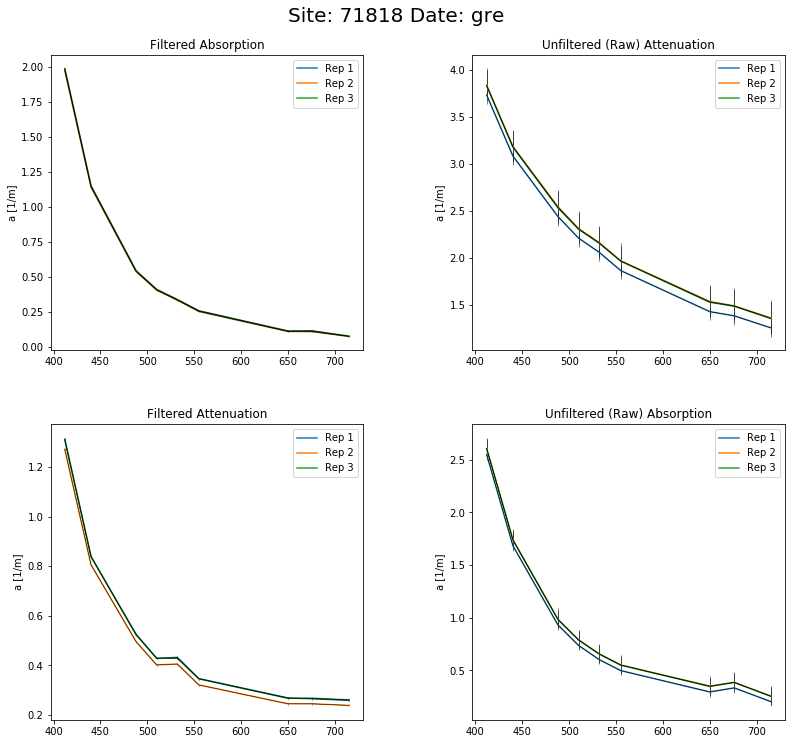

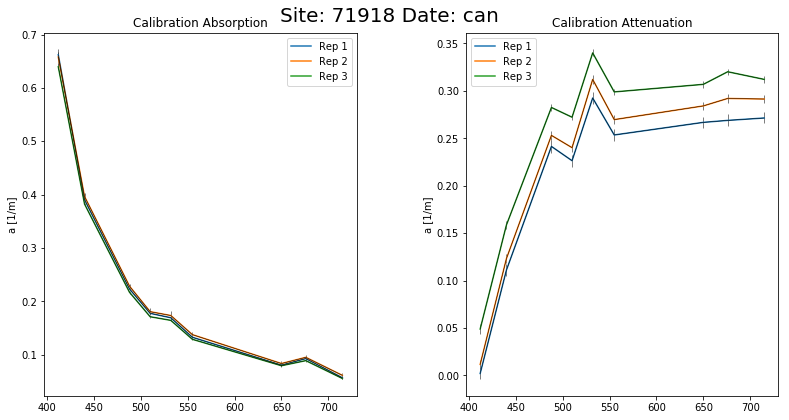

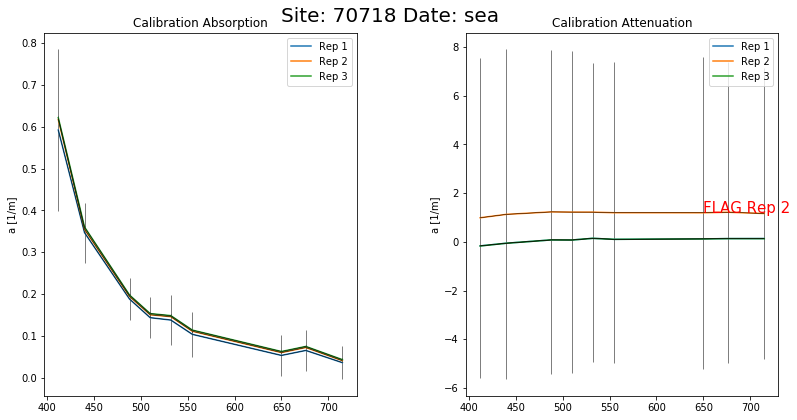

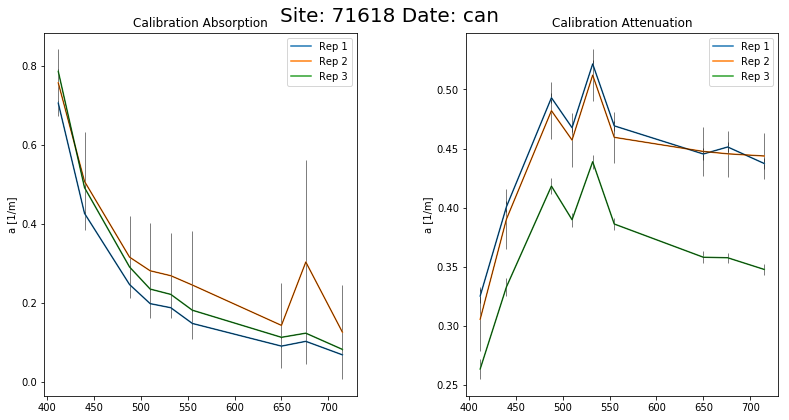

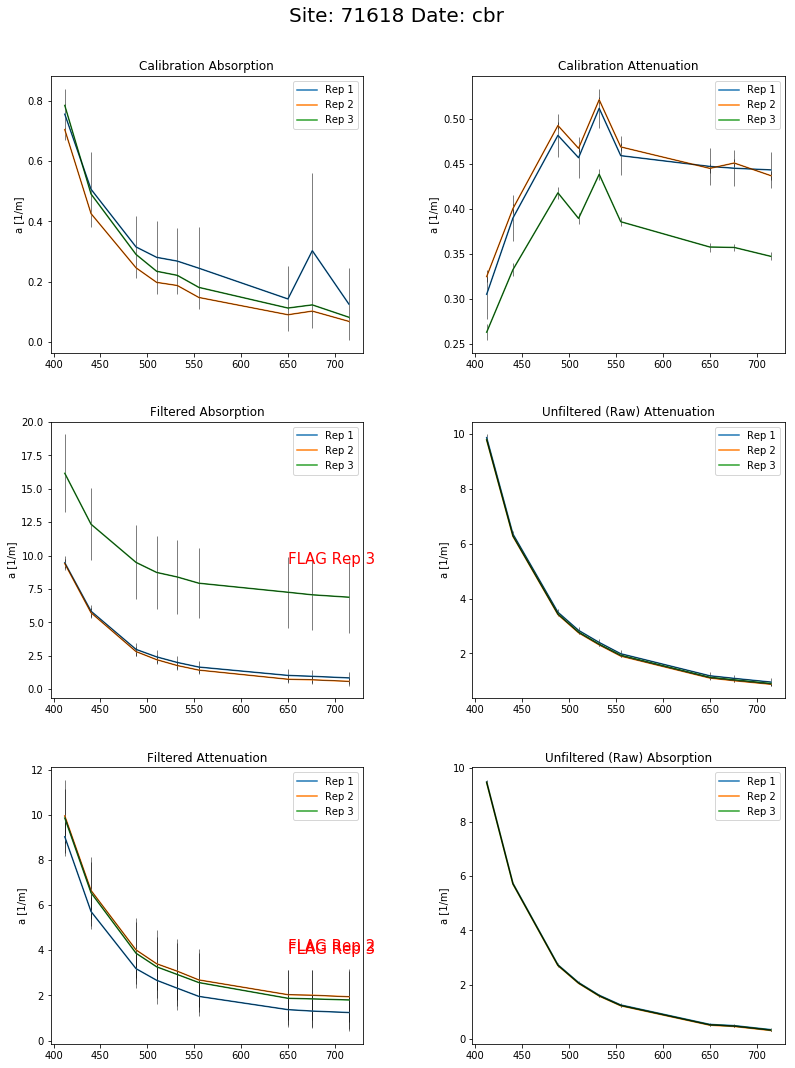

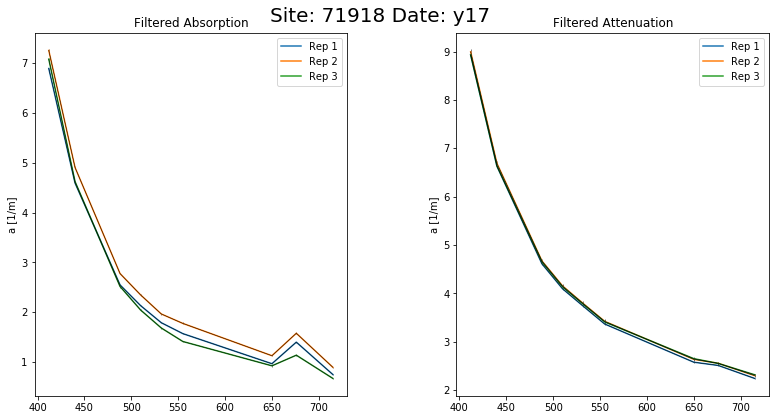

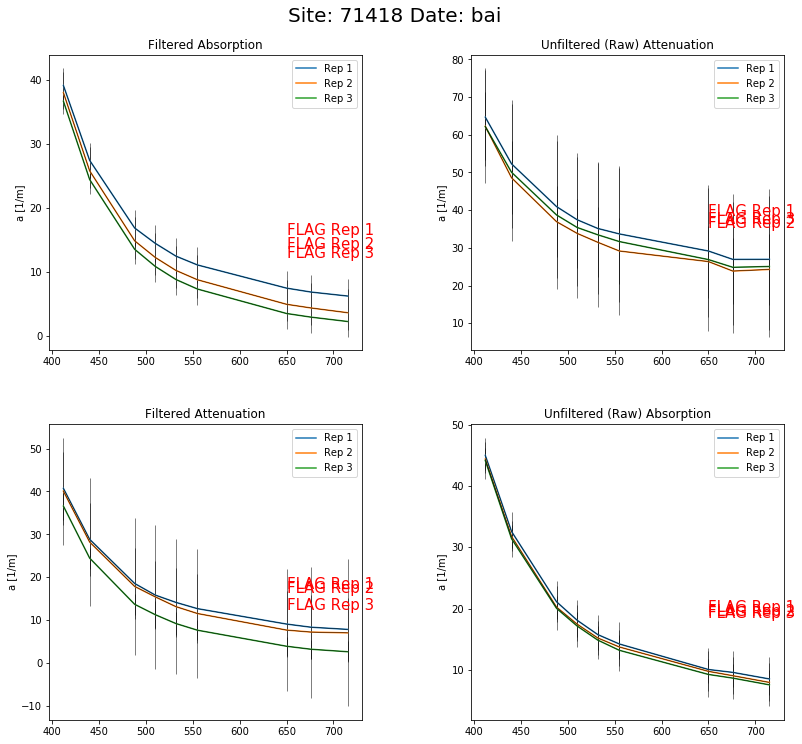

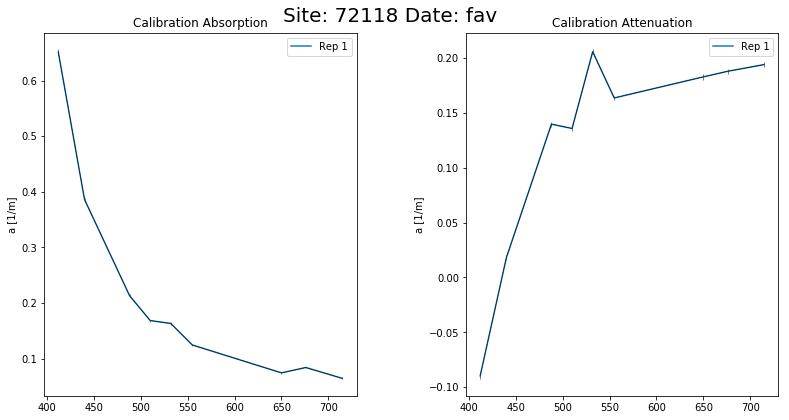

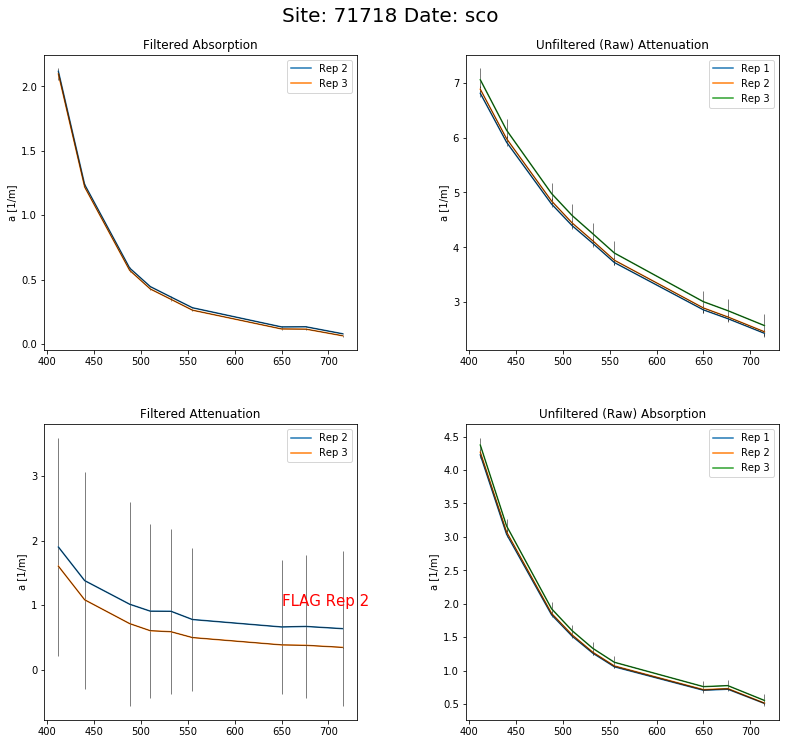

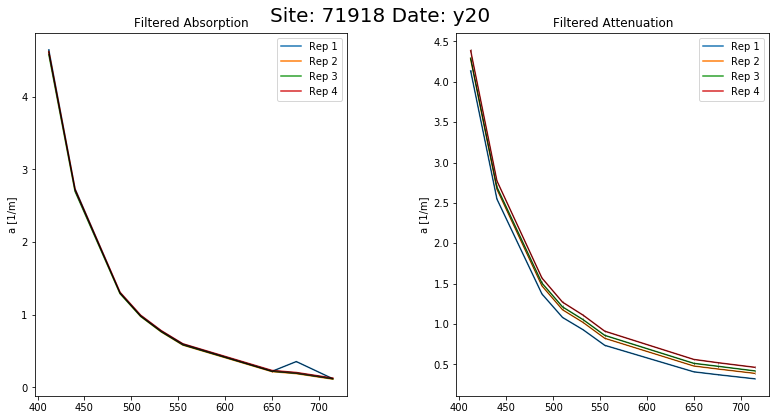

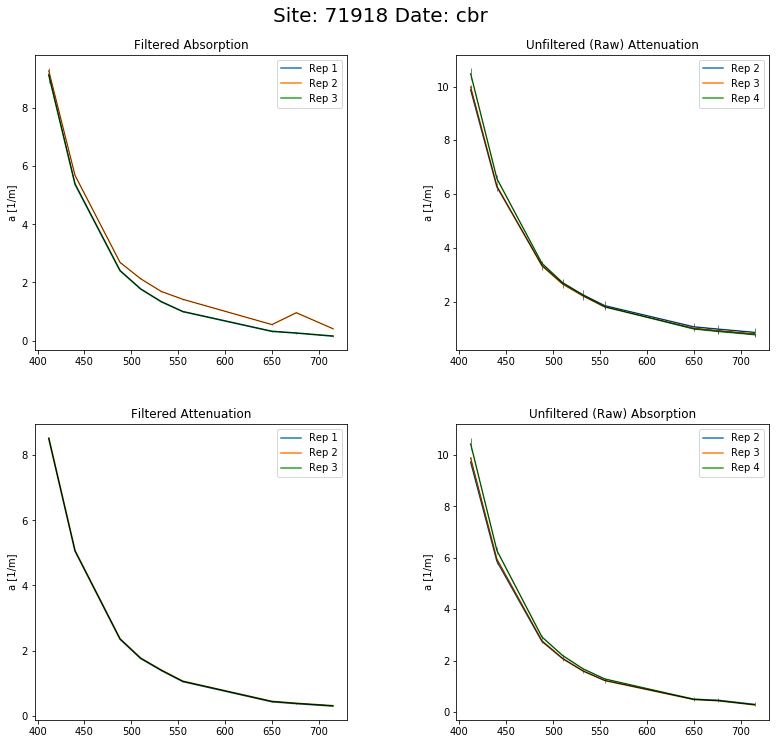

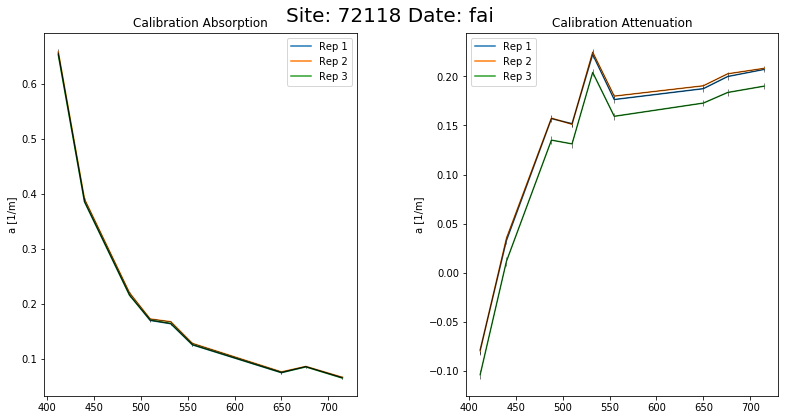

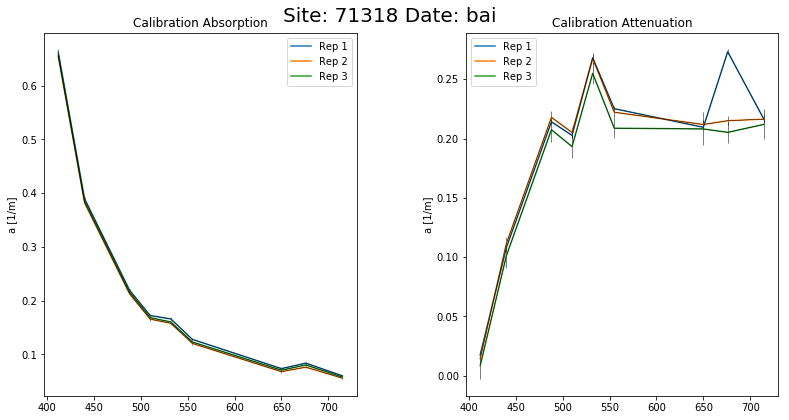

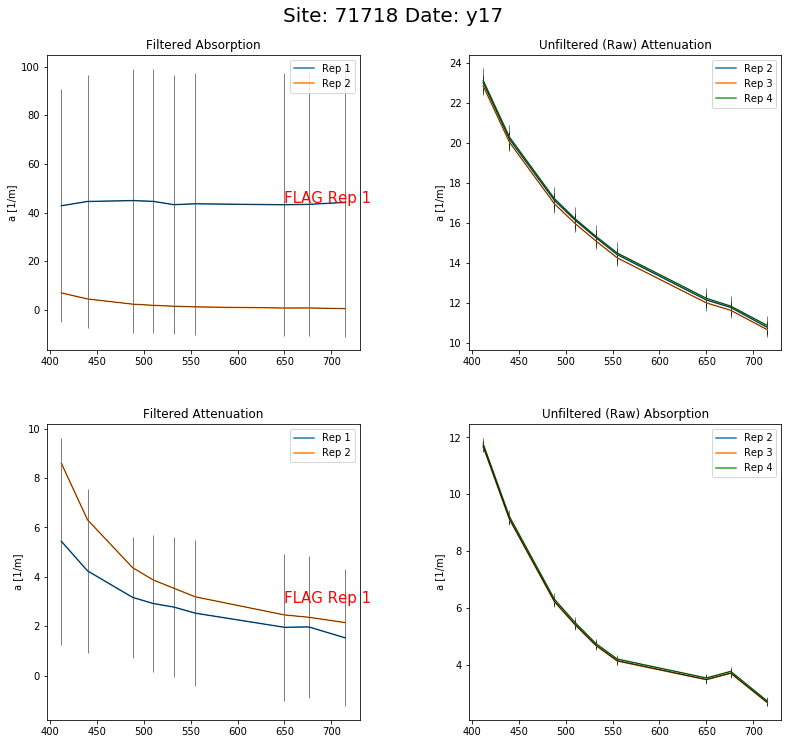

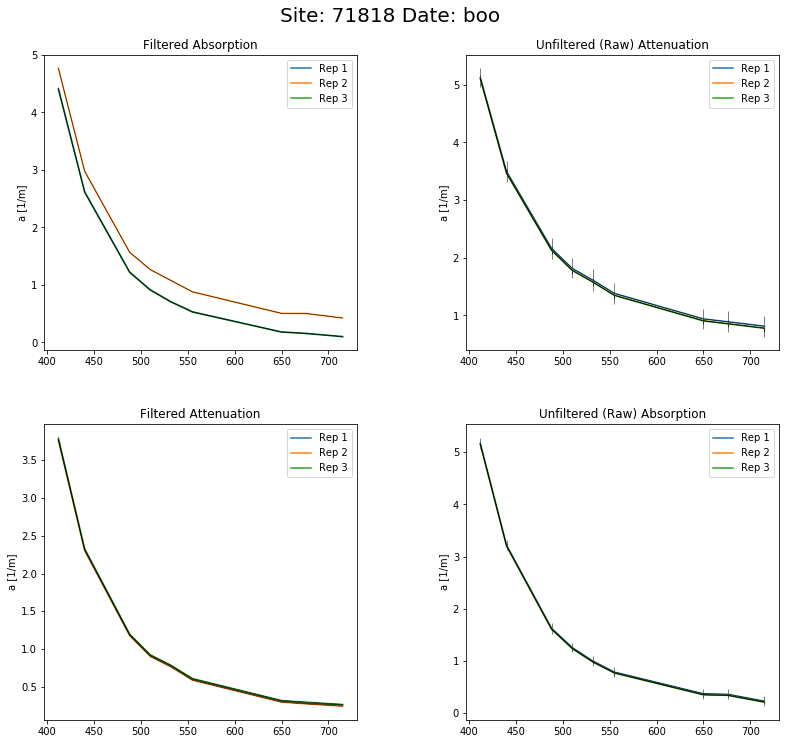

In [97]:
sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
abs_types = {'a':'Absorption','c':'Attenuation'}

for i in plotting_dict:
    num_of_plots = len(plotting_dict[i])
    num_of_rows = num_of_plots/2
    count = 0
    Date_all, Site_all = i.split('_')
    plt.subplots(num_of_rows, 2, figsize=(12, 5*num_of_rows+1))
    for sampleid in plotting_dict[i]:
        count += 1
        Sample_Type, Abs_Type = sampleid.split('_')
        plottitle = ' '.join([sample_types[Sample_Type],abs_types[Abs_Type]])
        plt.subplot(num_of_rows, 2, count)    
        my_plot = plotting_absorption(plotting_dict[i][sampleid], check=conf_check, title=plottitle)
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.show()